### Erddap Quicklooks of ThingSpeak archived data

__pyversion__==3.7   
__author__==S.Bell

__Notes:__ 

```
Home (shop) Station:   
Full Scale details... temp better at 25degC

DHT11 - 0-50C +/- 2degC, 0.1
      - 20-90% +/- 5%, 1
      
BMP180 - temp is +/- 2degc
       - baro is +/- 1hpa (and a 1hpa res for relative?)
       
--

Office Station - SParkFun redboard with BME280 T/RH/P
               - UV Sensor (VEML6075)
               
               - 20-80% RH is +/- 3%
               - baro is +/- 1hpa
               - temp is +/- 0.5degc
               
Lab EnvStation - SParkFun redboard with BME280 T/RH/P
               - CCSS8211 (AQ Sensor - eCO2 and VOC :  has collocated BME280 as well)
               
               - 20-80% RH is +/- 3%
               - baro is +/- 1hpa
               - temp is +/- 0.5degc
```

*relocation history*
- initially beside downdraft in back corner of office (until Jan?) UV data may indicate when moved
- moved to front side of fish tank (lamp may be slightly heating it) based on increase in temp when i arrive at office but no increase on remote work days... previous location appeared warmer though in late fall.


In [57]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2020-03-09 09:07:27.962198


In [1]:
stations = ['channel_843357_thingspeak','OfficeRedboard_WxStation','LabEnvMonitor']
station_accuracy = {stations[0]: {'Temp':2,'Baro':1,'RH':5},stations[1]: {'Temp':0.5,'Baro':1,'RH':3},stations[2]: {'Temp':0.5,'Baro':1,'RH':3}}


In [4]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import datetime

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

variables = [e.get_var_by_attr(dataset_id=prawler, standard_name=lambda v: v is not None) for prawler in stations]
print(variables)

[['SLP', 'temperature', 'Barotemperature', 'time', 'RH_Percent'], ['SLP', 'temperature', 'Altitude', 'UVB', 'time', 'UVindex', 'UVA', 'RH_Percent'], ['VOC', 'BPB', 'TempB', 'BP_AQ', 'Co2_Conc', 'RHB', 'time', 'Temp_AQ', 'RH_AQ']]


In [6]:
df_stations= {}

for ind, station in enumerate(stations):
    d = ERDDAP(server=server_url,
               protocol='tabledap',
               response='csv',
              )

    d.dataset_id=station
    
    d.variables =  [d.get_var_by_attr(dataset_id=prawler, standard_name=lambda v: v is not None) for prawler in [d.dataset_id]][0]

    d.constraints={'time>=': datetime.datetime.now()-datetime.timedelta(days=180),
                   'time<=': datetime.datetime.now()
                  }

    print(d.get_download_url())

    df = d.to_pandas(
        index_col='time (UTC)',
        parse_dates=True,
        skiprows=(1,)  # units information can be dropped.
    )
    
    #df.dropna(inplace=True)

    df.sort_index(inplace=True)
    df.columns = [x[1].split()[0] for x in enumerate(df.columns)]

    if df['SLP'].mean() > 90000:
        df[df['SLP'] > 110000] = np.nan
    else:
        df[df['SLP'] > 1100] = np.nan
    df.tail()
    
    df.rename(columns={"Barotemperature": "BaroTemp"},inplace=True)
    df.rename(columns={"temperature": "Temp"},inplace=True)
    df_stations.update({station: df})

In [ ]:
#get some nearby data
import requests
import xml.etree.ElementTree as ET

user_agent_url = 'https://w1.weather.gov/xml/current_obs/KPAE.xml'
kpae = {} #Payne Field
try:
    xml_data = requests.get(user_agent_url).content
    res = requests.get("http://w1.weather.gov/xml/current_obs/KPAE.xml")
    xml_tree = ET.fromstring(res.text)
    kpae['temp_c'] = xml_tree.find('temp_c').text
    kpae['relative_humidity'] = xml_tree.find('relative_humidity').text
    kpae['pressure_mb'] = xml_tree.find('pressure_mb').text
    kpae['observation_time_rfc822'] = xml_tree.find('observation_time_rfc822').text
    kpae['datetime'] = datetime.datetime.strptime(kpae['observation_time_rfc822'],'%a, %d %b %Y %H:%M:%S %z')
except:
    pass

kpae

In [95]:
kpae['observation_time_rfc822'] = xml_tree.find('observation_time_rfc822').text

In [96]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean
### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

Average difference between two sensors for all time: -0.5361530364582943
Average difference between two sensors for last two weeks: -5.012437185929666
Average difference between two sensors for last two days: nan


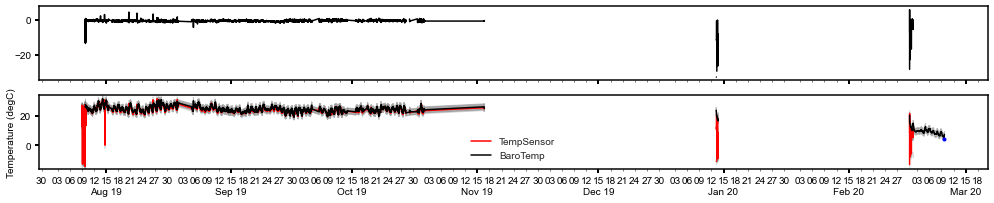

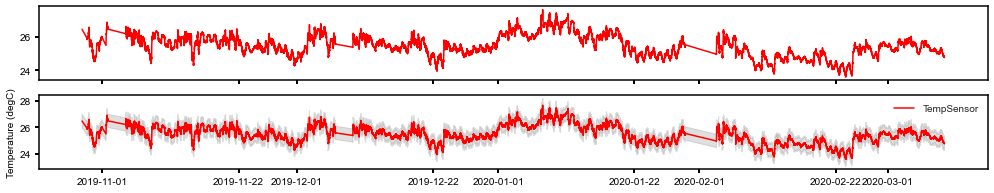

In [97]:
for i,dft in enumerate(df_stations):
    df=df_stations[dft]
    fig, (ax2, ax1) = plt.subplots(2,1,sharex='col',figsize=(17,3))
    try:
        df['BaroTemp']
        ax1.plot(df.index.values,df['Temp'],'r',df.index.values,df['BaroTemp'],'k')
        ax1.fill_between(df.index.values,df['Temp']-station_accuracy[dft]['Temp'],
                         df['Temp']+station_accuracy[dft]['Temp'],color='grey',alpha=.25)
        ax1.fill_between(df.index.values,df['BaroTemp']-station_accuracy[dft]['Temp'],
                         df['BaroTemp']+station_accuracy[dft]['Temp'],color='grey',alpha=.5)
        ax2.plot(df.index.values,df['Temp']-df['BaroTemp'],'k')
        plt.ylabel('Temperature (degC)')
        plt.legend(['TempSensor','BaroTemp'])
        local_station=True

        #ax1.set_xlim(df.index[0], df.index[-1])
        xfmt = mdates.DateFormatter('%d-%b')
        ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
        ax1.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
        ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
        ax1.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
        ax1.xaxis.set_tick_params(which='major', pad=3)
        ax1.xaxis.set_tick_params(which='minor', pad=5)

        print(f"Average difference between two sensors for all time: {(df['Temp']-df['BaroTemp']).mean()}")
        two_weeks_delta = (df['Temp'][df.last_valid_index()-pd.DateOffset(14, 'D'):] - 
                          df['BaroTemp'][df.last_valid_index()-pd.DateOffset(14, 'D'):]).mean()
        print(f"Average difference between two sensors for last two weeks: {two_weeks_delta}")
        two_days_delta = (df['Temp'][df.last_valid_index()-pd.DateOffset(2, 'D'):] - 
                          df['BaroTemp'][df.last_valid_index()-pd.DateOffset(2, 'D'):]).mean()
        print(f"Average difference between two sensors for last two days: {two_days_delta}")        
    except:
        ax1.plot(df.index.values,df['Temp'],'r',)
        ax1.fill_between(df.index.values,df['Temp']-station_accuracy[dft]['Temp'],
                         df['Temp']+station_accuracy[dft]['Temp'],color='grey',alpha=.25)
        ax2.plot(df.index.values,df['Temp'],'r')
        plt.ylabel('Temperature (degC)')
        plt.legend(['TempSensor'])
        local_station=False

    try:
        pass
        if local_station:
            ax1.plot(kpae['datetime'],np.float(kpae['temp_c']),'ob',markersize=3)
    except:
        pass
    



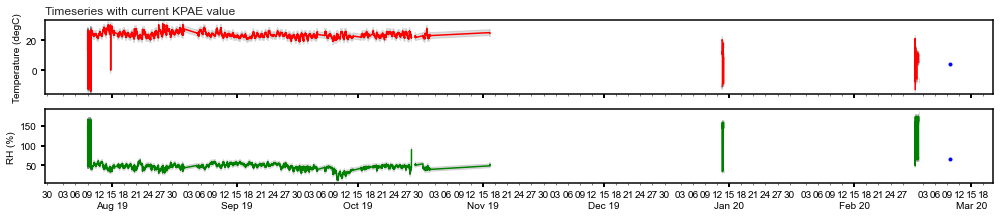

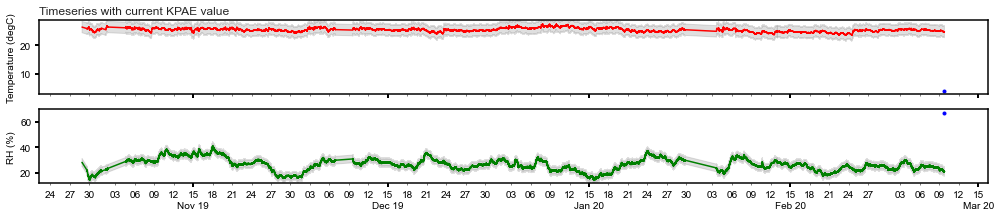

In [98]:
for i,dft in enumerate(df_stations):
    df=df_stations[dft]
    fig, (ax2, ax1) = plt.subplots(2,1,sharex='col',figsize=(17,3))
    ax2.set_title('Timeseries with current KPAE value',loc='left')
    ax1.plot(df.index.values,df['RH_Percent'],'g')
    ax1.fill_between(df.index.values,df['RH_Percent']-station_accuracy[dft]['RH'],
                     df['RH_Percent']+station_accuracy[dft]['RH'],
                     color='grey',alpha=.25)
    ax1.set_ylabel('RH (%)')
    ax2.plot(df.index.values,df['Temp'],'r')
    ax2.fill_between(df.index.values,df['Temp']-2,df['Temp']+2,
                     color='grey',alpha=.25)
    ax2.set_ylabel('Temperature (degC)')
    try:
        pass
        ax1.plot(kpae['datetime'],np.float(kpae['relative_humidity']),'ob',markersize=3)
        ax2.plot(kpae['datetime'],np.float(kpae['temp_c']),'ob',markersize=3)
    except:
        pass

    xfmt = mdates.DateFormatter('%d-%b')
    ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
    ax1.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
    ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
    ax1.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
    ax1.xaxis.set_tick_params(which='major', pad=3)
    ax1.xaxis.set_tick_params(which='minor', pad=5)
    #ax1.set_xlim([datetime.datetime.utcnow()-datetime.timedelta(days=30),datetime.datetime.utcnow()])


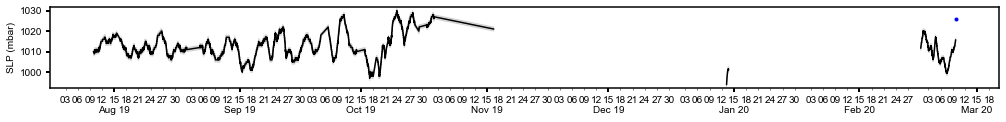

In [99]:
fig, ax1 = plt.subplots(1,1,sharex='col',figsize=(17,1.5))
for i,dft in enumerate(df_stations):
    if dft in ['channel_843357_thingspeak']:
        df=df_stations[dft]
        if df['SLP'].mean() >10000:
            ax1.plot(df.index.values,df['SLP']/100,'k')
            ax1.fill_between(df.index.values,df['SLP']/100-station_accuracy[dft]['Baro'],
                             df['SLP']/100+station_accuracy[dft]['Baro'],color='grey',alpha=.25)
        else:
            ax1.plot(df.index.values,df['SLP'],'k')
            ax1.fill_between(df.index.values,df['SLP']-station_accuracy[dft]['Baro'],df['SLP']+station_accuracy[dft]['Baro'],
                             color='grey',alpha=.25)
        plt.ylabel('SLP (mbar)')

        try:
            pass
            ax1.plot(kpae['datetime'],np.float(kpae['pressure_mb']),'ob',markersize=3)
        except:
            pass

        xfmt = mdates.DateFormatter('%d-%b')
        ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
        ax1.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
        ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
        ax1.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
        ax1.xaxis.set_tick_params(which='major', pad=3)
        ax1.xaxis.set_tick_params(which='minor', pad=5)

In [67]:
df = df_stations['channel_843357_thingspeak']
df = df_stations['OfficeRedboard_WxStation']
### build a table of daily max/min
daily_summary = pd.DataFrame(columns=df.columns)

for column in daily_summary:
    daily_summary[column+' (min)'] = df[column].resample('D').min()
    daily_summary[column+' (max)'] = df[column].resample('D').max()
    daily_summary[column+' (median)'] = df[column].resample('D').median()
    daily_summary[column] = df[column].resample('D').mean()
    
#TODO: export to HTML DataTable

In [68]:
def highlight_max(s):
    '''
    highlight the maximum in a Series red.
    '''
    is_max = s == s.max()
    return ['color: red' if v else '' for v in is_max]

def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['color: blue' if v else '' for v in is_min]



In [69]:
#daily_summary.style.apply(highlight_max).apply(highlight_min).format("{:.2f}")

In [70]:
#(daily_summary - daily_summary.mean()).style.bar(align='mid', color=['#d65f5f', '#5fba7d'])


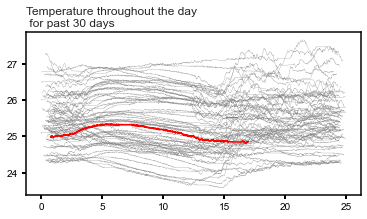

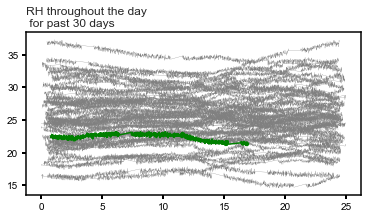

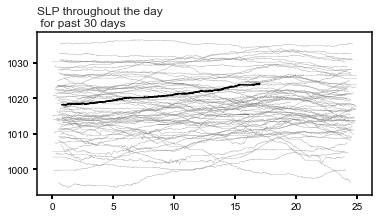

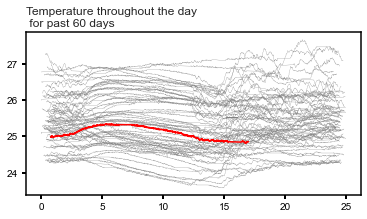

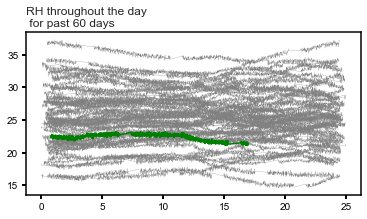

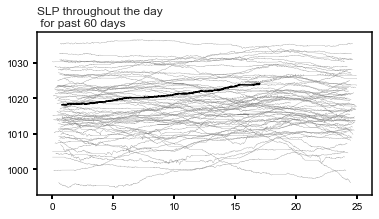

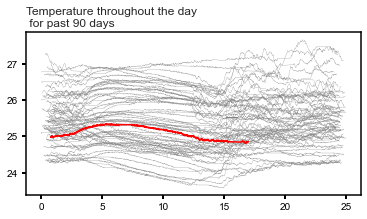

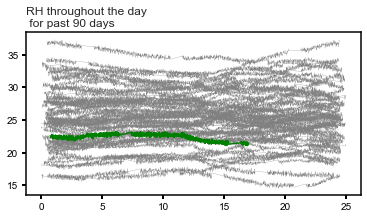

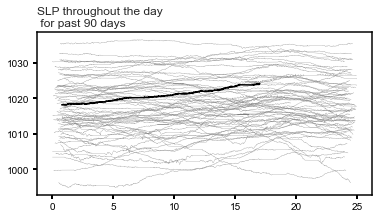

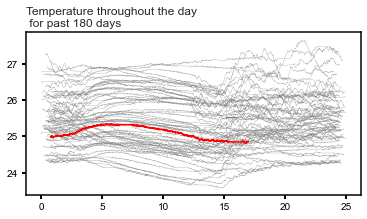

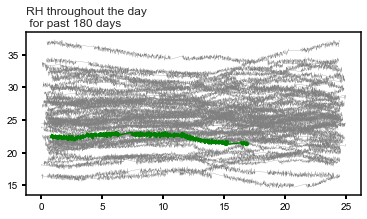

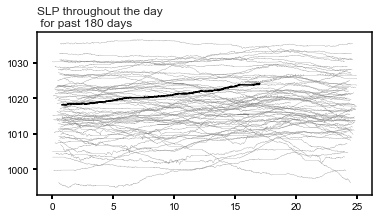

In [71]:
#office temperature as a function of time of day
dayperiod = [30,60,90,180]

#an update in pandas datetimes or matplotlib made plotting as function of datetime.time not work
for numdays in dayperiod:

    fig, (ax1) = plt.subplots(1,1,sharex='col',figsize=(6,3))
    ax1.set_title(f'Temperature throughout the day \n for past {numdays} days',loc='left')
    for name, group in df['2020'].groupby(df['2020'].index.date):
        hour = [x.hour +x.minute/60 + x.second/60 for x in group.index.time]
        ax1.plot(hour,group['Temp'],'grey',linewidth=.25)
    ax1.plot(hour,group['Temp'],'red')


    #RH
    fig, (ax1) = plt.subplots(1,1,sharex='col',figsize=(6,3))
    ax1.set_title(f'RH throughout the day \n for past {numdays} days',loc='left')
    for name, group in df['2020'].groupby(df['2020'].index.date):
        hour = [x.hour +x.minute/60 + x.second/60 for x in group.index.time]
        ax1.plot(hour,group['RH_Percent'],'grey',linewidth=.25)
    ax1.plot(hour,group['RH_Percent'],'green')


    #Press
    fig, (ax1) = plt.subplots(1,1,sharex='col',figsize=(6,3))
    ax1.set_title(f'SLP throughout the day \n for past {numdays} days',loc='left')
    for name, group in df['2020'].groupby(df['2020'].index.date):
        hour = [x.hour +x.minute/60 + x.second/60 for x in group.index.time]
        ax1.plot(hour,group['SLP']/100,'grey',linewidth=.25)
    ax1.plot(hour,group['SLP']/100,'black')




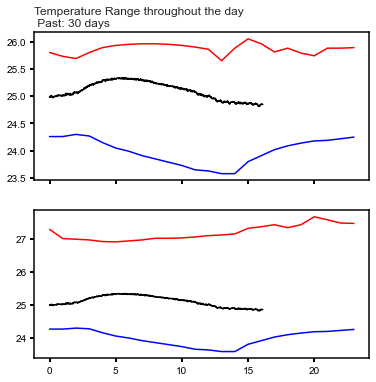

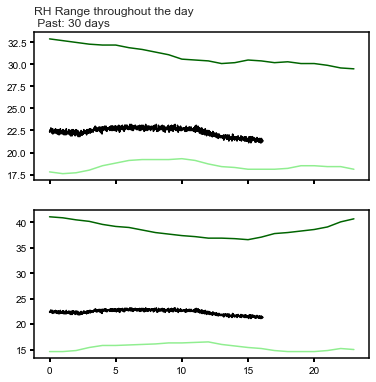

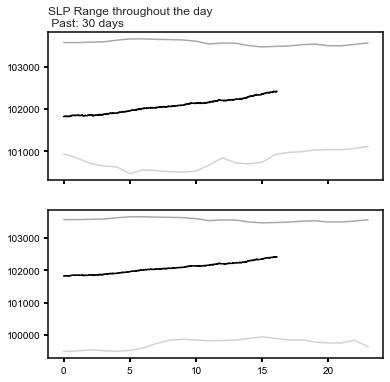

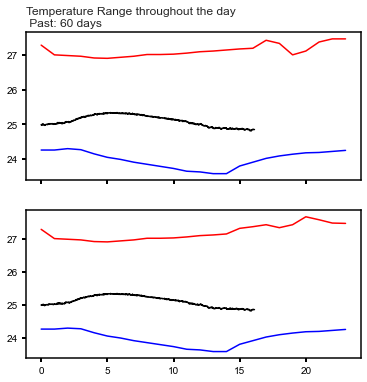

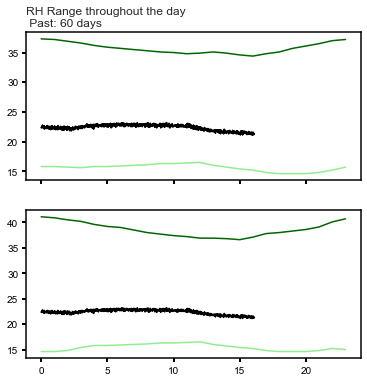

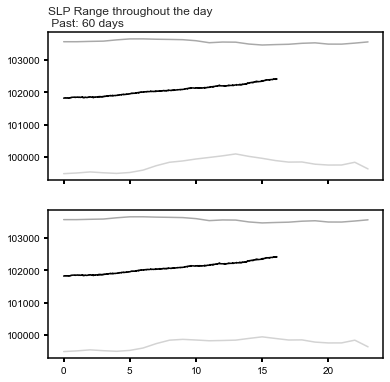

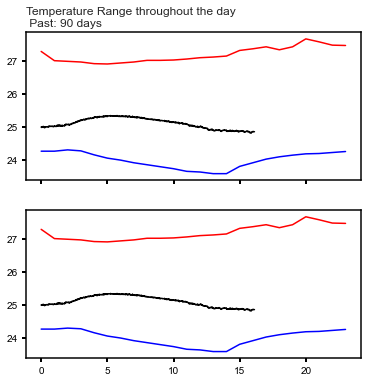

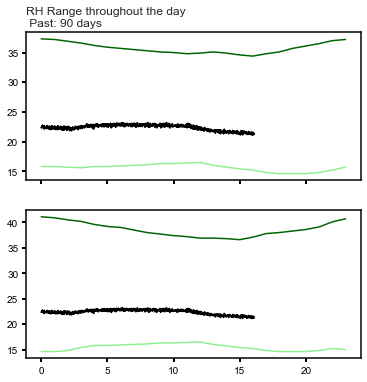

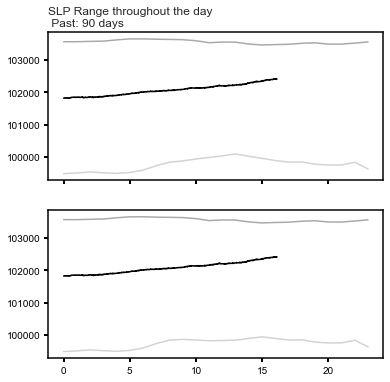

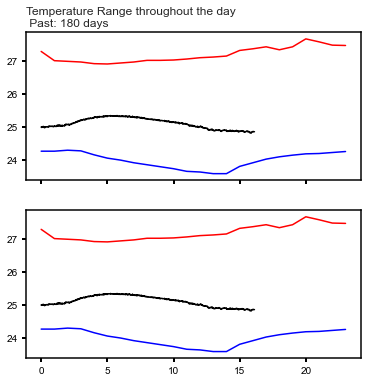

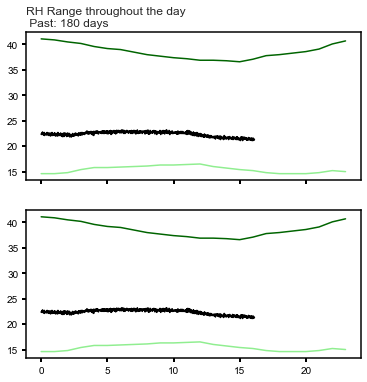

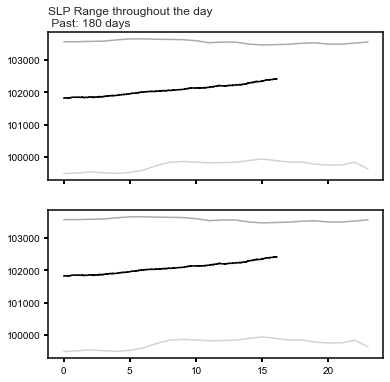

In [76]:
#max/min today
#office temperature as a function of time of day
#office temperature as a function of time of day
dayperiod = [30,60,90,180]

#an update in pandas datetimes or matplotlib made plotting as function of datetime.time not work
for numdays in dayperiod:

    df=df.resample('T').mean()
    dfsub = df[str((datetime.datetime.utcnow()-datetime.timedelta(days=numdays)).date()):str(datetime.datetime.utcnow().date())]

    fig, (ax1,ax2) = plt.subplots(2,1,sharex='col',figsize=(6,6))
    ax1.set_title(f'Temperature Range throughout the day \n Past: {numdays} days',loc='left')

    ax1.plot(dfsub.groupby(dfsub.index.hour).min().index,dfsub.groupby(dfsub.index.hour).min().Temp,'blue')
    ax1.plot(dfsub.groupby(dfsub.index.hour).max().index,dfsub.groupby(dfsub.index.hour).max().Temp,'red')
    ax1.plot(df[datetime.datetime.utcnow().date().strftime('%Y-%m-%d')].index.hour+df[datetime.datetime.utcnow().date().strftime('%Y-%m-%d')].index.minute/60
             ,df[datetime.datetime.utcnow().date().strftime('%Y-%m-%d')].Temp,'k')

    ax2.plot(df.groupby(df.index.hour).min().index,df.groupby(df.index.hour).min().Temp,'blue')
    ax2.plot(df.groupby(df.index.hour).max().index,df.groupby(df.index.hour).max().Temp,'red')
    ax2.plot(df[datetime.datetime.utcnow().date().strftime('%Y-%m-%d')].index.hour+df[datetime.datetime.utcnow().date().strftime('%Y-%m-%d')].index.minute/60
             ,df[datetime.datetime.utcnow().date().strftime('%Y-%m-%d')].Temp,'k')

    #RH
    fig, (ax1,ax2) = plt.subplots(2,1,sharex='col',figsize=(6,6))
    ax1.set_title(f'RH Range throughout the day \n Past: {numdays} days',loc='left')

    ax1.plot(dfsub.groupby(dfsub.index.hour).min().index,dfsub.groupby(dfsub.index.hour).min().RH_Percent,'lightgreen')
    ax1.plot(dfsub.groupby(dfsub.index.hour).max().index,dfsub.groupby(dfsub.index.hour).max().RH_Percent,'darkgreen')
    ax1.plot(df[datetime.datetime.utcnow().date().strftime('%Y-%m-%d')].index.hour+df[datetime.datetime.utcnow().date().strftime('%Y-%m-%d')].index.minute/60
             ,df[datetime.datetime.utcnow().date().strftime('%Y-%m-%d')].RH_Percent,'k')

    ax2.plot(df.groupby(df.index.hour).min().index,df.groupby(df.index.hour).min().RH_Percent,'lightgreen')
    ax2.plot(df.groupby(df.index.hour).max().index,df.groupby(df.index.hour).max().RH_Percent,'darkgreen')
    ax2.plot(df[datetime.datetime.utcnow().date().strftime('%Y-%m-%d')].index.hour+df[datetime.datetime.utcnow().date().strftime('%Y-%m-%d')].index.minute/60
             ,df[datetime.datetime.utcnow().date().strftime('%Y-%m-%d')].RH_Percent,'k')

    #SLP
    fig, (ax1,ax2) = plt.subplots(2,1,sharex='col',figsize=(6,6))
    ax1.set_title(f'SLP Range throughout the day \n Past: {numdays} days',loc='left')

    ax1.plot(dfsub.groupby(dfsub.index.hour).min().index,dfsub.groupby(dfsub.index.hour).min().SLP,'lightgrey')
    ax1.plot(dfsub.groupby(dfsub.index.hour).max().index,dfsub.groupby(dfsub.index.hour).max().SLP,'darkgrey')
    ax1.plot(df[datetime.datetime.utcnow().date().strftime('%Y-%m-%d')].index.hour+df[datetime.datetime.utcnow().date().strftime('%Y-%m-%d')].index.minute/60
             ,df[datetime.datetime.utcnow().date().strftime('%Y-%m-%d')].SLP,'k')

    ax2.plot(df.groupby(df.index.hour).min().index,df.groupby(df.index.hour).min().SLP,'lightgrey')
    ax2.plot(df.groupby(df.index.hour).max().index,df.groupby(df.index.hour).max().SLP,'darkgrey')
    ax2.plot(df[datetime.datetime.utcnow().date().strftime('%Y-%m-%d')].index.hour+df[datetime.datetime.utcnow().date().strftime('%Y-%m-%d')].index.minute/60
             ,df[datetime.datetime.utcnow().date().strftime('%Y-%m-%d')].SLP,'k')
